# Project Outline

1. Introduce the Client (Online Media Website)
2. Introduce Data Set / How I Clean the Data 
   - Load data set
   - Redo features to match current format if possible
   - breakout genres as binary features
   - conduct some EDA
3. Naive Recommender - (Popularity model) Recommend Most popular Movies / Most popular movies within Genres the user has liked
    - refit with new data set
4. Improved recommender (collaborative filtering, using different similarity functions between users) 
    - refit with new data set
    - finalize wording
5. Implicit Recommender (Light FM)
6. Significantly improved (using linear algebra techniques with Surprise, maybe ensembling if possible)
    - get surprise
    - try fitting different models
    - tune parameters
7. Conclusion
8. Next steps: big data solution with Spark / AWS  


# Creating a Movie Recommendation Engine

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

## Mathematical Defintion

Credit for the following section goes entirely to Diego Maniloff, Christian Fricke, and Zach Howard's Pycon presentation with Unata. 

### Notation

- $U$ is the set of users in our domain. Its size is $|U|$.
- $I$ is the set of items in our domain. Its size is $|I|$.
- $I(u)$ is the set of items that user $u$ has rated.
- $-I(u)$ is the complement of $I(u)$ i.e., the set of items not yet seen by user $u$.
- $U(i)$ is the set of users that have rated item $i$.
- $-U(i)$ is the complement of $U(i)$.
- $S(u,i)$ is a function that measures the utility of item $i$ for user $u$.

### Goal of a recommendation system

$
i^{*} = argmax_{i \in -I(u)} S(u,i), \forall{u \in U}
$

### Problem statement

The recommendation problem in its most basic form is quite simple to define:

```
|-------------------+-----+-----+-----+-----+-----|
| user_id, movie_id | m_1 | m_2 | m_3 | m_4 | m_5 |
|-------------------+-----+-----+-----+-----+-----|
| u_1               | ?   | ?   | 4   | ?   | 1   |
|-------------------+-----+-----+-----+-----+-----|
| u_2               | 3   | ?   | ?   | 2   | 2   |
|-------------------+-----+-----+-----+-----+-----|
| u_3               | 3   | ?   | ?   | ?   | ?   |
|-------------------+-----+-----+-----+-----+-----|
| u_4               | ?   | 1   | 2   | 1   | 1   |
|-------------------+-----+-----+-----+-----+-----|
| u_5               | ?   | ?   | ?   | ?   | ?   |
|-------------------+-----+-----+-----+-----+-----|
| u_6               | 2   | ?   | 2   | ?   | ?   |
|-------------------+-----+-----+-----+-----+-----|
| u_7               | ?   | ?   | ?   | ?   | ?   |
|-------------------+-----+-----+-----+-----+-----|
| u_8               | 3   | 1   | 5   | ?   | ?   |
|-------------------+-----+-----+-----+-----+-----|
| u_9               | ?   | ?   | ?   | ?   | 2   |
|-------------------+-----+-----+-----+-----+-----|
```

*Given a partially filled matrix of ratings ($|U|x|I|$), estimate the missing values.*


## In English

Out of movies that a user hasn't seen, which ones will that user be likely to enjoy? We want to recommend these movies

# The Data and Data Wrangling

- 1,000,209 anonymous ratings
- ~3,900 movies
- ratings by 6,040 MovieLens users
- users joined MovieLens in 2000
- all data is provided by users voluntarily

## Describe your data set, and how you cleaned/wrangled it¶


Data is formatted a little funnily, working with dat files where data is seperated by "::" markers. Start by reading and joining the three data sets - the list of movies, the list of ratings, and the the list of users.

In [3]:
movies = pd.read_table('movies.dat', sep="::", header=None, names=['movie_id', 'movie_title', 'genre'], engine='python')

In [4]:
ratings = pd.read_table('ratings.dat', sep="::", header=None, names=['user_id','movie_id','rating','timestamp'], engine='python')

In [5]:
users = pd.read_table('users.dat', sep='::', names =['user_id', 'gender', 'age', 'occupation', 'zip_code'] , engine='python')

In [6]:
# create one merged DataFrame
movie_ratings = pd.merge(movies, ratings, on="movie_id")
full_set = pd.merge(movie_ratings, users, on="user_id")

In [7]:
full_set.isnull().sum()
len(full_set)

1000209

Great! Now that we have a full data set to work with and no other NA values, let's wrangle the data so that all the columns are as meaningful as possible.

In [8]:
full_set.head()

,movie_id,movie_title,genre,user_id,rating,timestamp,gender,age,occupation,zip_code
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,1,10,48067
4,527,Schindler's List (1993),Drama|War,1,5,978824195,F,1,10,48067


We can gain further information from this data by splitting the aggregate genre column into individual genres. We can also feature engineer on the timestamp to further classify the data. We will return to feature engineering as needed.

## Naive Recommender


In [41]:
# Get number of ratings by movie and convert to Pandas DataFrame
num_ratings_by_movie = full_set.groupby('movie_title').size()
num_ratings_by_movie = pd.DataFrame({'movie_title':num_ratings_by_movie.index, 'total ratings': num_ratings_by_movie.values})
# Get mean rating by movie
mean_rating_by_movie = (full_set.groupby('movie_title'))['movie_title','rating'].mean()
mean_rating_by_movie['movie_title'] = mean_rating_by_movie.index

In [42]:
most_popular_movies = pd.merge(mean_rating_by_movie, num_ratings_by_movie).sort_values(by = 'total ratings', ascending= False)

In [43]:
# Sort most popular movies by rating 
movies_to_recommend_naive = most_popular_movies[:100].sort_values(by = 'rating', ascending = False)
movies_to_recommend_naive.head()

,rating,movie_title,total ratings
2970,4.555,"Shawshank Redemption, The (1994)",2227
1354,4.525,"Godfather, The (1972)",2223
3504,4.517,"Usual Suspects, The (1995)",1783
2901,4.510,Schindler's List (1993),2304
2711,4.478,Raiders of the Lost Ark (1981),2514


By our naive approach, we would recommend the Shawshank Redemption, The Godfather, the Usual Suspects, Schindler's List, and Raiders of the Lost Ark. If the user has seen these movies, we would systematically move down the list until we hit a movie the user hasn't seen yet.

# Better Recommenders

#### Pre processing
Subset data for speed - we will use the entire data set when running this code on AWS later.
Then split the result into training and testing sets.

In [44]:
# Subset data, take 10,000 values
model_data = full_set.ix[np.random.choice(full_set.index, size=10000, replace=False)]

In [45]:
# Subset sampled data set to make sure there are at least 2 ratings per user
user_ids_larger_1 = pd.value_counts(model_data.user_id, sort=False) > 1
user_ids_larger_1 = user_ids_larger_1[user_ids_larger_1].index
model_data = model_data.select(lambda l: model_data.loc[l, 'user_id'] in user_ids_larger_1)
print(model_data.shape)
assert np.all(model_data.user_id.value_counts() > 1)

(8472, 10)


We now generate train and test subsets by marking 20% of each users's ratings as test, using groupby and apply.

In [46]:
# Split the data into train / test sets (80% and 20% respectively)
def assign_to_set(df):
    sampled_ids = np.random.choice(df.index,
                                   size=np.int64(np.ceil(df.index.size * 0.2)),
                                   replace=False)
    df.ix[sampled_ids, 'for_testing'] = True
    return df

model_data['for_testing'] = False
grouped = model_data.groupby('user_id', group_keys=False).apply(assign_to_set)
model_data_train = model_data[grouped.for_testing == False]
model_data_test = model_data[grouped.for_testing == True]
print(model_data.shape)
print(model_data_train.shape)
print(model_data_test.shape)
assert len(model_data_train.index & model_data_test.index) == 0

(8472, 11)
(5829, 11)
(2643, 11)


### Evaluation

In [2]:
# Evaulate the performance of our models with root mean square error
def compute_rmse(y_pred, y_true):    
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

In [48]:
def evaluate(estimate_f):
    """ RMSE-based predictive performance evaluation with pandas. """
    
    ids_to_estimate = zip(model_data_test.user_id, model_data_test.movie_id)
    estimated = np.array([estimate_f(u,i) for (u,i) in ids_to_estimate])
    real = model_data_test.rating.values
    return compute_rmse(estimated, real)

In [49]:
def evaluate_precision(estimate_f):
    """ RMSE-based predictive performance evaluation with pandas. """
    
    ids_to_estimate = zip(model_data_test.user_id, model_data_test.movie_id)
    estimated = np.array([estimate_f(u,i) for (u,i) in ids_to_estimate])
    real = model_data_test.rating.values
    return compute_precision(estimated, real)

In [50]:
def my_estimate_function(user_id, movie_id):
    return 3

In [51]:
print('RMSE for my estimate function: %s' % evaluate(my_estimate_function))

RMSE for my estimate function: 1.26464182903


#### Content-based filtering
Recommend based on the user's rating history.
 
#### Collaborative filtering
Recommend based on other user's rating histories.

#### Hybrid solutions
The literature has lots of examples of systems that try to combine the strengths of the two main approaches. This can be done in a number of ways:
- Combine the predictions of a content-based system and a collaborative system.
- Incorporate content-based techniques into a collaborative approach.
- Incorporarte collaborative techniques into a content-based approach.
- Unifying model.

### Limitations

#### Availability of item metadata

Content-based techniques are limited by the amount of metadata that is available to describe an item. There are domains in which feature extraction methods are expensive or time consuming, e.g., processing multimedia data such as graphics, audio/video streams. In the context of grocery items for example, it's often the case that item information is only partial or completely missing. Examples include:
- Ingredients
- Nutrition facts
- Brand
- Description
- County of origin

#### New user problem
A user has to have rated a sufficient number of items before a recommender system can have a good idea of what their preferences are. In a content-based system, the aggregation function needs ratings to aggregate.
#### New item problem
Collaborative filters rely on an item being rated by many users to compute aggregates of those ratings. Think of this as the exact counterpart of the new user problem for content-based systems.
#### Data sparsity
When looking at the more general versions of content-based and collaborative systems, the success of the recommender system depends on the availability of a critical mass of user/item iteractions. We get a first glance at the data sparsity problem by quantifying the ratio of existing ratings vs  |U|x|I||U|x|I| . A highly sparse matrix of interactions makes it difficult to compute similarities between users and items. As an example, for a user whose tastes are unusual compared to the rest of the population, there will not be any other users who are particularly similar, leading to poor recommendations.

### Content-based filtering using mean ratings

Takes mean of user's ratings

In [52]:
# Returns mean of user_id's ratings 
def content_mean(user_id, movie_id):
    """ Simple content-filtering based on mean ratings. """
    
    user_condition = model_data_train.user_id == user_id
    return model_data_train.loc[user_condition, 'rating'].mean()

print('RMSE for estimate1: %s' % evaluate(content_mean))

RMSE for estimate1: 1.27188652393


### Collaborative-based filtering using implicit similarity functions 
(Reference below for pretty math formulas) Account for similarities when calculating content / collab filtering

In [53]:
# Add Index to easily access user info
user_info = users.set_index('user_id')

In [54]:
# Returns collab filter mean (Mean of ratings for a given movie by everyone else of the same gender. 
#Base case is rating of 3
def collab_gender(user_id, movie_id):
    """ Collaborative filtering using an implicit sim(u,u') based on gender. """
    
    user_condition = model_data_train.user_id != user_id
    movie_condition = model_data_train.movie_id == movie_id
    ratings_by_others = model_data_train.loc[user_condition & movie_condition]
    if ratings_by_others.empty: 
        return 3.0
    
    means_by_gender = ratings_by_others.pivot_table('rating', index='movie_id', columns='gender')
    user_gender = user_info.ix[user_id, 'gender']
    if user_gender in means_by_gender.columns: 
        return means_by_gender.ix[movie_id, user_gender]
    else:
        return means_by_gender.ix[movie_id].mean()

print('RMSE for collab_gender: %s' % evaluate(collab_gender))

RMSE for collab_gender: 1.21764267913


At this point it seems worthwhile to write a learn function to pre-compute whatever datastructures we need at estimation time.



In [55]:
class CollabGenderReco:
    """ Collaborative filtering using an implicit sim(u,u'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.means_by_gender = model_data_train.pivot_table('rating', index='movie_id', columns='gender')

    def estimate(self, user_id, movie_id):
        """ Mean ratings by other users of the same gender. """
        
        if movie_id not in self.means_by_gender.index: 
            return 3.0
        
        user_gender = user_info.ix[user_id, 'gender']
        if ~np.isnan(self.means_by_gender.ix[movie_id, user_gender]):
            return self.means_by_gender.ix[movie_id, user_gender]
        else:
            return self.means_by_gender.ix[movie_id].mean()

reco = CollabGenderReco()
reco.learn()
print('RMSE for CollabGenderReco: %s' % evaluate(reco.estimate))

RMSE for CollabGenderReco: 1.21764267913


In [56]:
class CollabAgeReco:
    """ Collaborative filtering using an implicit sim(u,u'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.means_by_age = model_data_train.pivot_table('rating', index='movie_id', columns='age')

    def estimate(self, user_id, movie_id):
        """ Mean ratings by other users of the same age. """
        
        if movie_id not in self.means_by_age.index: 
            return 3.0
        
        user_age = user_info.ix[user_id, 'age']
        if ~np.isnan(self.means_by_age.ix[movie_id, user_age]):
            return self.means_by_age.ix[movie_id, user_age]
        else:
            return self.means_by_age.ix[movie_id].mean()

reco = CollabAgeReco()
reco.learn()
print('RMSE for CollabAgeReco: %s' % evaluate(reco.estimate))

RMSE for CollabAgeReco: 1.255131437


In [57]:
class CollabZipCodeReco:
    """ Collaborative filtering using an implicit sim(u,u'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.means_by_zip = model_data_train.pivot_table('rating', index='movie_id', columns='zip_code')

    def estimate(self, user_id, movie_id):
        """ Mean ratings by other users of the same zip code. """
        
        if movie_id not in self.means_by_zip.index: 
            return 3.0
        
        user_zip = user_info.ix[user_id, 'zip_code']
        if ~np.isnan(self.means_by_zip.ix[movie_id, user_zip]):
            return self.means_by_zip.ix[movie_id, user_zip]
        else:
            return self.means_by_zip.ix[movie_id].mean()

reco = CollabZipCodeReco()
reco.learn()
print('RMSE for CollabZipCodeReco: %s' % evaluate(reco.estimate))

RMSE for CollabZipCodeReco: 1.17321689745


In [58]:
class CollabOccupationReco:
    """ Collaborative filtering using an implicit sim(u,u'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.means_by_occupation = model_data_train.pivot_table('rating', index='movie_id', columns='occupation')

    def estimate(self, user_id, movie_id):
        """ Mean ratings by other users of the same occupation. """
        
        if movie_id not in self.means_by_occupation.index: 
            return 3.0
        
        user_occupation = user_info.ix[user_id, 'occupation']
        if ~np.isnan(self.means_by_occupation.ix[movie_id, user_occupation]):
            return self.means_by_occupation.ix[movie_id, user_occupation]
        else:
            return self.means_by_occupation.ix[movie_id].mean()

reco = CollabOccupationReco()
reco.learn()
print('RMSE for CollabOccupationReco: %s' % evaluate(reco.estimate))

RMSE for CollabOccupationReco: 1.22968948602


## Minimal reco engine v1.2: custom similarity functions


### A few similarity functions

These were all written to operate on two pandas Series, each one representing the rating history of two different users. You can also apply them to any two feature vectors that describe users or items. In all cases, the higher the return value, the more similar two Series are. You might need to add checks for edge cases, such as divisions by zero, etc.

- Euclidean 'similarity'

$$ sim(x,y) = \frac{1}{1 + \sqrt{\sum (x - y)^2}}$$

In [59]:
def euclidean(s1, s2):
    """Take two pd.Series objects and return their euclidean 'similarity'."""
    diff = s1 - s2
    return 1 / (1 + np.sqrt(np.sum(diff ** 2)))

- Cosine similarity

$$ sim(x,y) = \frac{(x . y)}{\sqrt{(x . x) (y . y)}} $$

In [60]:
def cosine(s1, s2):
    """Take two pd.Series objects and return their cosine similarity."""
    return np.sum(s1 * s2) / np.sqrt(np.sum(s1 ** 2) * np.sum(s2 ** 2))

- Pearson correlation

$$ sim(x,y) = \frac{(x - \bar x).(y - \bar y)}{\sqrt{(x - \bar x).(x - \bar x) * (y - \bar y)(y - \bar y)}} $$

In [61]:
def pearson(s1, s2):
    """Take two pd.Series objects and return a pearson correlation."""
    s1_c = s1 - s1.mean()
    s2_c = s2 - s2.mean()
    return np.sum(s1_c * s2_c) / np.sqrt(np.sum(s1_c ** 2) * np.sum(s2_c ** 2))

- Jaccard similarity

$$ sim(x,y) = \frac{(x . y)}{(x . x) + (y . y) - (x . y)} $$

In [62]:
def jaccard(s1, s2):
    dotp = np.sum(s1 * s2)
    return dotp / (np.sum(s1 ** 2) + np.sum(s2 ** 2) - dotp)

def binjaccard(s1, s2):
    dotp = (s1.index & s2.index).size
    return dotp / (s1.sum() + s2.sum() - dotp)

In [63]:
class CollabJaccardReco:
    """ Collaborative filtering using a custom sim(u,u'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.all_user_profiles = model_data.pivot_table('rating', index='movie_id', columns='user_id')

    def estimate(self, user_id, movie_id):
        """ Ratings weighted by correlation similarity. """
        
        user_condition = model_data_train.user_id != user_id
        movie_condition = model_data_train.movie_id == movie_id
        ratings_by_others = model_data_train.loc[user_condition & movie_condition]
        if ratings_by_others.empty: 
            return 3.0
        
        ratings_by_others.set_index('user_id', inplace=True)
        their_ids = ratings_by_others.index
        their_ratings = ratings_by_others.rating
        their_profiles = self.all_user_profiles[their_ids]
        user_profile = self.all_user_profiles[user_id]
        sims = their_profiles.apply(lambda profile: jaccard(profile, user_profile), axis=0)
        ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)
        
reco = CollabJaccardReco()
reco.learn()
print('RMSE for CollabJaccardReco: %s' % evaluate(reco.estimate))

RMSE for CollabJaccardReco: 1.16681890376


In [64]:
class CollabBinJaccardReco:
    """ Collaborative filtering using a custom sim(u,u'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.all_user_profiles = model_data.pivot_table('rating', index='movie_id', columns='user_id')

    def estimate(self, user_id, movie_id):
        """ Ratings weighted by correlation similarity. """
        
        user_condition = model_data_train.user_id != user_id
        movie_condition = model_data_train.movie_id == movie_id
        ratings_by_others = model_data_train.loc[user_condition & movie_condition]
        if ratings_by_others.empty: 
            return 3.0
        
        ratings_by_others.set_index('user_id', inplace=True)
        their_ids = ratings_by_others.index
        their_ratings = ratings_by_others.rating
        their_profiles = self.all_user_profiles[their_ids]
        user_profile = self.all_user_profiles[user_id]
        sims = their_profiles.apply(lambda profile: binjaccard(profile, user_profile), axis=0)
        ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)
        
reco = CollabBinJaccardReco()
reco.learn()
print('RMSE for CollabBinJaccardReco: %s' % evaluate(reco.estimate))

RMSE for CollabBinJaccardReco: 1.17369068504


In [65]:
class CollabCosineReco:
    """ Collaborative filtering using a custom sim(u,u'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.all_user_profiles = model_data.pivot_table('rating', index='movie_id', columns='user_id')

    def estimate(self, user_id, movie_id):
        """ Ratings weighted by correlation similarity. """
        
        user_condition = model_data_train.user_id != user_id
        movie_condition = model_data_train.movie_id == movie_id
        ratings_by_others = model_data_train.loc[user_condition & movie_condition]
        if ratings_by_others.empty: 
            return 3.0
        
        ratings_by_others.set_index('user_id', inplace=True)
        their_ids = ratings_by_others.index
        their_ratings = ratings_by_others.rating
        their_profiles = self.all_user_profiles[their_ids]
        user_profile = self.all_user_profiles[user_id]
        sims = their_profiles.apply(lambda profile: cosine(profile, user_profile), axis=0)
        ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)
        
reco = CollabCosineReco()
reco.learn()
print('RMSE for CollabCosineReco: %s' % evaluate(reco.estimate))

RMSE for CollabCosineReco: 1.17128694235


In [66]:
class CollabEuclideanReco:
    """ Collaborative filtering using a custom sim(u,u'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.all_user_profiles = model_data.pivot_table('rating', index='movie_id', columns='user_id')

    def estimate(self, user_id, movie_id):
        """ Ratings weighted by correlation similarity. """
        
        user_condition = model_data_train.user_id != user_id
        movie_condition = model_data_train.movie_id == movie_id
        ratings_by_others = model_data_train.loc[user_condition & movie_condition]
        if ratings_by_others.empty: 
            return 3.0
        
        ratings_by_others.set_index('user_id', inplace=True)
        their_ids = ratings_by_others.index
        their_ratings = ratings_by_others.rating
        their_profiles = self.all_user_profiles[their_ids]
        user_profile = self.all_user_profiles[user_id]
        sims = their_profiles.apply(lambda profile: euclidean(profile, user_profile), axis=0)
        ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)
        
reco = CollabEuclideanReco()
reco.learn()
print('RMSE for CollabEuclideanReco: %s' % evaluate(reco.estimate))

RMSE for CollabEuclideanReco: 1.05059654126


In [67]:
class CollabPearsonReco:
    """ Collaborative filtering using a custom sim(u,u'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.all_user_profiles = model_data.pivot_table('rating', index='movie_id', columns='user_id')

    def estimate(self, user_id, movie_id):
        """ Ratings weighted by correlation similarity. """
        
        user_condition = model_data_train.user_id != user_id
        movie_condition = model_data_train.movie_id == movie_id
        ratings_by_others = model_data_train.loc[user_condition & movie_condition]
        if ratings_by_others.empty: 
            return 3.0
        
        ratings_by_others.set_index('user_id', inplace=True)
        their_ids = ratings_by_others.index
        their_ratings = ratings_by_others.rating
        their_profiles = self.all_user_profiles[their_ids]
        user_profile = self.all_user_profiles[user_id]
        sims = their_profiles.apply(lambda profile: pearson(profile, user_profile), axis=0)
        ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)
        
reco = CollabPearsonReco()
reco.learn()
print('RMSE for CollabPearsonReco: %s' % evaluate(reco.estimate))

RMSE for CollabPearsonReco: 1.12208448768


## Further Improved Recommendations with Surprise

In [16]:
from surprise import SVD
from surprise import Dataset
from surprise import evaluate, print_perf


# Load the movielens-100k dataset (download it if needed),
# and split it into 3 folds for cross-validation.
data = Dataset.load_builtin('ml-1m')
data.split(n_folds=3)

# We'll use the famous SVD algorithm.
algo = SVD()

# Evaluate performances of our algorithm on the dataset.
perf = evaluate(algo, data, measures=['RMSE', 'MAE'])

print_perf(perf)

Dataset ml-1m could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-1m.zip...
Done! Dataset ml-1m has been saved to /Users/Akaash/.surprise_data/ml-1m
Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.8851
MAE:  0.6958
------------
Fold 2
RMSE: 0.8842
MAE:  0.6952
------------
Fold 3
RMSE: 0.8863
MAE:  0.6963
------------
------------
Mean RMSE: 0.8852
Mean MAE : 0.6958
------------
------------
        Fold 1  Fold 2  Fold 3  Mean    
RMSE    0.8851  0.8842  0.8863  0.8852  
MAE     0.6958  0.6952  0.6963  0.6958  


See http://surpriselib.com/ for the other algorithms. 

## Light FM - Implicit Recommendation System

In section, we explore Light FM's implicit recommendation solution to the Movie Recommendation Engine Problem

Credit : https://github.com/lyst/lightfm/tree/master/examples/movielens

In [9]:
import numpy as np
#import data

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import auc_score

movielens = fetch_movielens()

train, test = movielens['train'], movielens['test']

In [4]:
for key, value in movielens.items():
    print(key, type(value), value.shape)

item_features <class 'scipy.sparse.csr.csr_matrix'> (1682, 1682)
train <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)
item_feature_labels <class 'numpy.ndarray'> (1682,)
item_labels <class 'numpy.ndarray'> (1682,)
test <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)


In [5]:
train = movielens['train']
test = movielens['test']

In [6]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

model = LightFM(learning_rate=0.05, loss='bpr')
model.fit(train, epochs=10)

train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.59, test 0.10.
AUC: train 0.90, test 0.86.


In [7]:
model = LightFM(learning_rate=0.05, loss='warp')

model.fit_partial(train, epochs=10)

train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.61, test 0.11.
AUC: train 0.94, test 0.90.


## Playing with Learning Rates

From LightFM - "To evaluate the performance of both learning schedules, let's create two models and run each for a number of epochs, measuring the ROC AUC on the test set at the end of each epoch."

In [10]:
alpha = 1e-3
epochs = 70

adagrad_model = LightFM(no_components=30,
                        loss='warp',
                        learning_schedule='adagrad',
                        user_alpha=alpha,
                        item_alpha=alpha)
adadelta_model = LightFM(no_components=30,
                        loss='warp',
                        learning_schedule='adadelta',
                        user_alpha=alpha,
                        item_alpha=alpha)

adagrad_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(train, epochs=1)
    adagrad_auc.append(auc_score(adagrad_model, test).mean())
    
    
adadelta_auc = []

for epoch in range(epochs):
    adadelta_model.fit_partial(train, epochs=1)
    adadelta_auc.append(auc_score(adadelta_model, test).mean())

"It looks like the adadelta gets to a better result at the beginning of training. However, as we keep running more epochs adagrad wins out, converging to a better final solution."

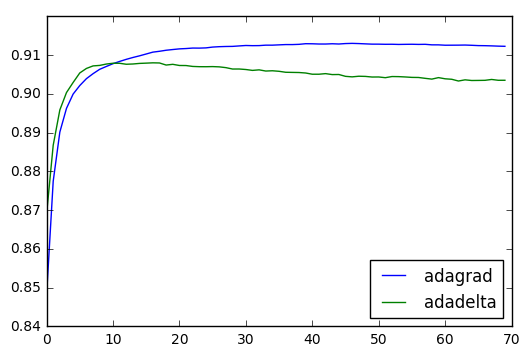

In [11]:
x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()

In [12]:
alpha = 1e-3
epochs = 70

adagrad_model = LightFM(no_components=30,
                        loss='warp-kos',
                        learning_schedule='adagrad',
                        user_alpha=alpha, item_alpha=alpha)
adadelta_model = LightFM(no_components=30,
                        loss='warp-kos',
                        learning_schedule='adadelta',
                        user_alpha=alpha, item_alpha=alpha)

adagrad_auc = []

for epoch in range(epochs):
    adagrad_model.fit_partial(train, epochs=1)
    adagrad_auc.append(auc_score(adagrad_model, test).mean())
    
    
adadelta_auc = []

for epoch in range(epochs):
    adadelta_model.fit_partial(train, epochs=1)
    adadelta_auc.append(auc_score(adadelta_model, test).mean())

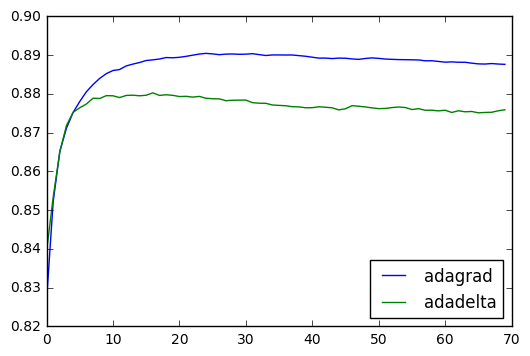

In [13]:
x = np.arange(len(adagrad_auc))
plt.plot(x, np.array(adagrad_auc))
plt.plot(x, np.array(adadelta_auc))
plt.legend(['adagrad', 'adadelta'], loc='lower right')
plt.show()

## Next steps: Big data solution with Spark

We can use Spark's Alternating Least Squares solution to the movie recommender problem as well.
Some sample code, Credit: https://github.com/databricks/spark-training/blob/master/machine-learning/python/solution/MovieLensALS.py

In [28]:
import findspark
findspark.init()
import pyspark
#sc = pyspark.SparkContext()

In [ ]:
import sys
import itertools
from math import sqrt
from operator import add
from os.path import join, isfile, dirname

from pyspark import SparkConf, SparkContext
from pyspark.mllib.recommendation import ALS

def parseRating(line):
    """
    Parses a rating record in MovieLens format userId::movieId::rating::timestamp .
    """
    fields = line.strip().split("::")
    return int(fields[3]) % 10, (int(fields[0]), int(fields[1]), float(fields[2]))

def parseMovie(line):
    """
    Parses a movie record in MovieLens format movieId::movieTitle .
    """
    fields = line.strip().split("::")
    return int(fields[0]), fields[1]

def loadRatings(ratingsFile):
    """
    Load ratings from file.
    """
    if not isfile(ratingsFile):
        print("File %s does not exist." % ratingsFile)
        sys.exit(1)
    f = open(ratingsFile, 'r')
    ratings = filter(lambda r: r[2] > 0, [parseRating(line)[1] for line in f])
    f.close()
    if not ratings:
        print("No ratings provided.")
        sys.exit(1)
    else:
        return ratings

def computeRmse(model, data, n):
    """
    Compute RMSE (Root Mean Squared Error).
    """
    predictions = model.predictAll(data.map(lambda x: (x[0], x[1])))
    predictionsAndRatings = predictions.map(lambda x: ((x[0], x[1]), x[2])) \
      .join(data.map(lambda x: ((x[0], x[1]), x[2]))) \
      .values()
    return sqrt(predictionsAndRatings.map(lambda x: (x[0] - x[1]) ** 2).reduce(add) / float(n))

if __name__ == "__main__":
    if (len(sys.argv) != 3):
        print("Usage: /path/to/spark/bin/spark-submit --driver-memory 2g " + \
          "MovieLensALS.py movieLensDataDir personalRatingsFile")
        sys.exit(1)

    # set up environment
    conf = SparkConf() \
      .setAppName("MovieLensALS") \
      .set("spark.executor.memory", "2g")
    sc = SparkContext(conf=conf)

    # load personal ratings
    myRatings = loadRatings(sys.argv[2])
    myRatingsRDD = sc.parallelize(myRatings, 1)
    
    # load ratings and movie titles

    movieLensHomeDir = sys.argv[1]

    # ratings is an RDD of (last digit of timestamp, (userId, movieId, rating))
    ratings = sc.textFile(join(movieLensHomeDir, "ratings.dat")).map(parseRating)

    # movies is an RDD of (movieId, movieTitle)
    movies = dict(sc.textFile(join(movieLensHomeDir, "movies.dat")).map(parseMovie).collect())

    numRatings = ratings.count()
    numUsers = ratings.values().map(lambda r: r[0]).distinct().count()
    numMovies = ratings.values().map(lambda r: r[1]).distinct().count()

    print("Got %d ratings from %d users on %d movies." % (numRatings, numUsers, numMovies))

    # split ratings into train (60%), validation (20%), and test (20%) based on the 
    # last digit of the timestamp, add myRatings to train, and cache them

    # training, validation, test are all RDDs of (userId, movieId, rating)

    numPartitions = 4
    training = ratings.filter(lambda x: x[0] < 6) \
      .values() \
      .union(myRatingsRDD) \
      .repartition(numPartitions) \
      .cache()

    validation = ratings.filter(lambda x: x[0] >= 6 and x[0] < 8) \
      .values() \
      .repartition(numPartitions) \
      .cache()

    test = ratings.filter(lambda x: x[0] >= 8).values().cache()

    numTraining = training.count()
    numValidation = validation.count()
    numTest = test.count()

    print("Training: %d, validation: %d, test: %d" % (numTraining, numValidation, numTest))

    # train models and evaluate them on the validation set

    ranks = [8, 12]
    lambdas = [0.1, 10.0]
    numIters = [10, 20]
    bestModel = None
    bestValidationRmse = float("inf")
    bestRank = 0
    bestLambda = -1.0
    bestNumIter = -1

    for rank, lmbda, numIter in itertools.product(ranks, lambdas, numIters):
        model = ALS.train(training, rank, numIter, lmbda)
        validationRmse = computeRmse(model, validation, numValidation)
        print("RMSE (validation) = %f for the model trained with " % validationRmse + \
              "rank = %d, lambda = %.1f, and numIter = %d." % (rank, lmbda, numIter))
        if (validationRmse < bestValidationRmse):
            bestModel = model
            bestValidationRmse = validationRmse
            bestRank = rank
            bestLambda = lmbda
            bestNumIter = numIter

    testRmse = computeRmse(bestModel, test, numTest)

    # evaluate the best model on the test set
    print("The best model was trained with rank = %d and lambda = %.1f, " % (bestRank, bestLambda) \
      + "and numIter = %d, and its RMSE on the test set is %f." % (bestNumIter, testRmse))

    # compare the best model with a naive baseline that always returns the mean rating
    meanRating = training.union(validation).map(lambda x: x[2]).mean()
    baselineRmse = sqrt(test.map(lambda x: (meanRating - x[2]) ** 2).reduce(add) / numTest)
    improvement = (baselineRmse - testRmse) / baselineRmse * 100
    print("The best model improves the baseline by %.2f" % (improvement) + "%.")

    # make personalized recommendations

    myRatedMovieIds = set([x[1] for x in myRatings])
    candidates = sc.parallelize([m for m in movies if m not in myRatedMovieIds])
    predictions = bestModel.predictAll(candidates.map(lambda x: (0, x))).collect()
    recommendations = sorted(predictions, key=lambda x: x[2], reverse=True)[:50]

    print("Movies recommended for you:")
    for i in xrange(len(recommendations)):
        print ("%2d: %s" % (i + 1, movies[recommendations[i][1]])).encode('ascii', 'ignore')

    # clean up
    sc.stop()


### Resources / References

Read "Components of Recommendation Engine" section:
https://github.com/guymorita/recommendationRaccoon/

Different Distance Metrics:
http://www.benfrederickson.com/distance-metrics/

Surprise:
https://pypi.python.org/pypi/scikit-surprise

Nice LightFM Tutorial:
https://www.youtube.com/watch?v=9gBC9R-msAk

General Guide:
http://blogs.gartner.com/martin-kihn/how-to-build-a-recommender-system-in-python/

Using Spark/Flask:
https://github.com/jadianes/spark-movie-lens/blob/master/notebooks/building-recommender.ipynb


- Goldberg, D., D. Nichols, B. M. Oki, and D. Terry. “Using Collaborative Filtering to Weave an Information Tapestry.” Communications of the ACM 35, no. 12 (1992): 61–70.
- Resnick, Paul, and Hal R. Varian. “Recommender Systems.” Commun. ACM 40, no. 3 (March 1997): 56–58. doi:10.1145/245108.245121.
- Adomavicius, Gediminas, and Alexander Tuzhilin. “Toward the Next Generation of Recommender Systems: A Survey of the State-of-the-Art and Possible Extensions.” IEEE Transactions on Knowledge and Data Engineering 17, no. 6 (2005): 734–749. doi:http://doi.ieeecomputersociety.org/10.1109/TKDE.2005.99.
- Adomavicius, Gediminas, Ramesh Sankaranarayanan, Shahana Sen, and Alexander Tuzhilin. “Incorporating Contextual Information in Recommender Systems Using a Multidimensional Approach.” ACM Trans. Inf. Syst. 23, no. 1 (2005): 103–145. doi:10.1145/1055709.1055714.
- Koren, Y., R. Bell, and C. Volinsky. “Matrix Factorization Techniques for Recommender Systems.” Computer 42, no. 8 (2009): 30–37.
- William Wesley McKinney. Python for Data Analysis. O’Reilly, 2012.
- Toby Segaran. Programming Collective Intelligence. O’Reilly, 2007.
- Zhou, Tao, Zoltan Kuscsik, Jian-Guo Liu, Matus Medo, Joseph R Wakeling, and Yi-Cheng Zhang. “Solving the Apparent Diversity-accuracy Dilemma of Recommender Systems.” arXiv:0808.2670 (August 19, 2008). doi:10.1073/pnas.1000488107.
- Shani, G., D. Heckerman, and R. I Brafman. “An MDP-based Recommender System.” Journal of Machine Learning Research 6, no. 2 (2006): 1265.
- Joseph A. Konstan, John Riedl. "Deconstructing Recommender Systems." IEEE Spectrum, October 2012.